In [1]:
import pandas as pd
import numpy as np
import os
os.chdir('../../../../')
print(os.getcwd())
from v2.strategy.indicators.optimal_v2 import Optimal_v2
from v2.model import Trading
from v2.strategy.indicators.param import Param
from v2.strategy.indicators.roc import RateOfChange
from v2.research.scripts.notebook_utils import notebookUtils
from v2.research.scripts.scoreboard import updateScoreboard
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from xgboost import XGBClassifier
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression

/home/marshingjay/Repos/moonshot/back_testing


In [2]:
nu = notebookUtils()
model_name = "kingmaker"

In [3]:
dataset, features, indicators = nu.loadData(indicators=[('BOP', 'close'), ('PSAR', 'close'), ('optimal_v2', 'close')],
                            param_spec={},
                            optimal_threshold={'buy':0.01},
                            
                            spans=[
                                    {'indicator_name':'natr',
                                    'column_name': 'close',
                                    'param_name': 'period',
                                    'param_values': [30, 300]},
                                    {'indicator_name':'cmo',
                                    'column_name': 'close',
                                    'param_name': 'period',
                                    'param_values': [2, 10, 30, 200]},
                                    {'indicator_name':'jti',
                                    'column_name': 'close',
                                    'param_name': 'period',
                                    'param_values': [60, 300, 1500]},
                                    ],

                            scale='minmaxwindow')

        
    # create one minute, five minute, ten minute, and twenty minute slopes for macd, rsi




Loading data from BTC...
Loading data from chunk 0...
Loading data from chunk 1...
Loading data from chunk 2...
Loading data from chunk 3...
Loading data from chunk 4...
Loading data from chunk 5...
Loading data from chunk 6...
Loading data from chunk 7...
Loading data from chunk 8...
Loading data from chunk 9...
Loading data from chunk 10...


In [4]:
dataset

,time,high,low,close,open,volume,BOP,PSAR,optimal,NATR_close_period_30,...,JTI_close_period_60_c,JTI_close_period_60_theta,JTI_close_period_300_a,JTI_close_period_300_b,JTI_close_period_300_c,JTI_close_period_300_theta,JTI_close_period_1500_a,JTI_close_period_1500_b,JTI_close_period_1500_c,JTI_close_period_1500_theta
16553,1505732339999,3928.00,3890.00,3919.372502,3910.02,1.500586,0.736579,0.444596,0.0,0.228299,...,7.355646e-02,0.011866,0.962205,0.811465,4.034800e-02,8.011122e-05,0.324782,0.183213,2.371353e-13,0.002760
16554,1505732399999,3931.23,3910.01,3925.301251,3910.01,1.137323,1.000000,0.444390,0.0,0.233245,...,7.355646e-02,0.011635,0.963780,0.812739,4.034800e-02,7.389688e-05,0.325295,0.183502,2.371353e-13,0.002754
16555,1505732459999,3943.98,3928.00,3934.640626,3928.00,1.361729,1.000000,0.422889,0.0,0.236176,...,5.512659e-01,0.164394,0.965354,0.814013,4.034800e-02,6.770271e-05,0.325808,0.183792,2.371353e-13,0.002748
16556,1505732519999,3945.00,3943.98,3939.820313,3943.98,2.542339,1.000000,0.434521,0.0,0.233999,...,5.512659e-01,0.131179,0.966929,0.815287,4.034800e-02,6.152779e-05,0.326321,0.184081,2.371353e-13,0.002742
16557,1505732579999,3945.00,3945.00,3942.410156,3945.00,0.753785,0.500000,0.449368,0.0,0.228787,...,5.512659e-01,0.111297,0.968504,0.816561,4.034800e-02,5.537219e-05,0.326834,0.184370,2.371353e-13,0.002736
16558,1505732639999,3945.00,3945.00,3943.705078,3945.00,0.072722,0.500000,0.462136,0.0,0.222198,...,5.512659e-01,0.097679,0.970079,0.817834,4.034800e-02,4.923595e-05,0.327347,0.184660,2.371353e-13,0.002730
16559,1505732699999,3960.00,3959.99,3951.852539,3959.99,0.237661,1.000000,0.436505,0.0,0.224044,...,5.512659e-01,0.087638,0.971654,0.819108,4.034800e-02,4.311990e-05,0.327860,0.184949,2.371353e-13,0.002724
16560,1505732759999,3960.00,3960.00,3955.926270,3960.00,0.126035,0.500000,0.453156,0.0,0.220937,...,5.512659e-01,0.079784,0.973228,0.820382,4.034800e-02,3.702273e-05,0.328374,0.185239,2.371323e-13,0.002718
16561,1505732819999,3964.99,3935.00,3945.463135,3964.99,0.078431,0.000000,0.528161,0.0,0.232544,...,5.512659e-01,0.073370,0.974803,0.821656,4.034800e-02,3.094314e-05,0.328887,0.185528,2.371323e-13,0.002712
16562,1505732879999,3964.99,3964.99,3955.226567,3964.99,0.121893,0.500000,0.467371,0.0,0.235948,...,5.512659e-01,0.068119,0.976378,0.822930,4.034800e-02,2.488497e-05,0.329400,0.185818,2.371323e-13,0.002706


In [153]:
dataset.drop(["time", "open", "high", "low", "volume"], axis=1, inplace=True)
dataset.dropna(inplace=True)


ValueError: labels ['time' 'open' 'high' 'low' 'volume'] not contained in axis

In [154]:
trainX, testX, trainy, testy = nu.splitData(dataset, split_size=0.2, y_column_name="optimal", shuffle_data=False, balance_unbalanced_data=True, balance_info={'multiplier_val':16, 'superset_class_val':0, 'randomize_concat':True})
len(trainX)

48688

In [155]:
class_weights = nu.getWeights(trainy)
class_weights

{0: 0.53125, 1: 8.5}

In [156]:
clf = RandomForestClassifier(random_state=69420, class_weight=class_weights, n_jobs=-1, n_estimators=100, criterion='gini', min_samples_leaf=2)
clf.fit(trainX.drop("close", axis=1).values, trainy.values)
print(clf.score(testX.drop("close", axis=1).values, testy.values))



0.9949957879605228


In [157]:


feature_importances = permutation_importance(clf, trainX.drop("close", axis=1).values, trainy.values, n_repeats=10, random_state=69420)

for i in range(len(feature_importances.importances_mean)):
    print('i: {}, Feature: {}, Score: {}'.format(i, trainX.drop("close", axis=1).columns[i], feature_importances.importances_mean[i]))

i: 0, Feature: BOP, Score: 0.020629313177785137
i: 1, Feature: PSAR, Score: 0.02810754189944139
i: 2, Feature: NATR_close_period_30, Score: 0.03855570161025309
i: 3, Feature: NATR_close_period_300, Score: 0.03211468945119953
i: 4, Feature: CMO_close_period_2, Score: 0.042464262241209375
i: 5, Feature: CMO_close_period_10, Score: 0.04321187972395666
i: 6, Feature: CMO_close_period_30, Score: 0.03150468287873813
i: 7, Feature: CMO_close_period_200, Score: 0.0169692737430168
i: 8, Feature: JTI_close_period_60_a, Score: 0.005331909300032911
i: 9, Feature: JTI_close_period_60_b, Score: 0.004282369372329975
i: 10, Feature: JTI_close_period_60_c, Score: 0.004044117647058865
i: 11, Feature: JTI_close_period_60_theta, Score: 0.005420226749917878
i: 12, Feature: JTI_close_period_300_a, Score: 0.003890075583305996
i: 13, Feature: JTI_close_period_300_b, Score: 0.0034258954978639957
i: 14, Feature: JTI_close_period_300_c, Score: 0.005214837331580724
i: 15, Feature: JTI_close_period_300_theta, Scor

0.9710026199658399


In [235]:
reduced_classified_data = nu.classifyPoints([clf], testX, predict_proba=True, proba_thresh=[0.6], plot_optimal=True, optimal=testy)

In [236]:
smaller_view_data = reduced_classified_data[200000:225000]
smaller_view_data.reset_index(inplace=True)

<Figure size 432x288 with 0 Axes>

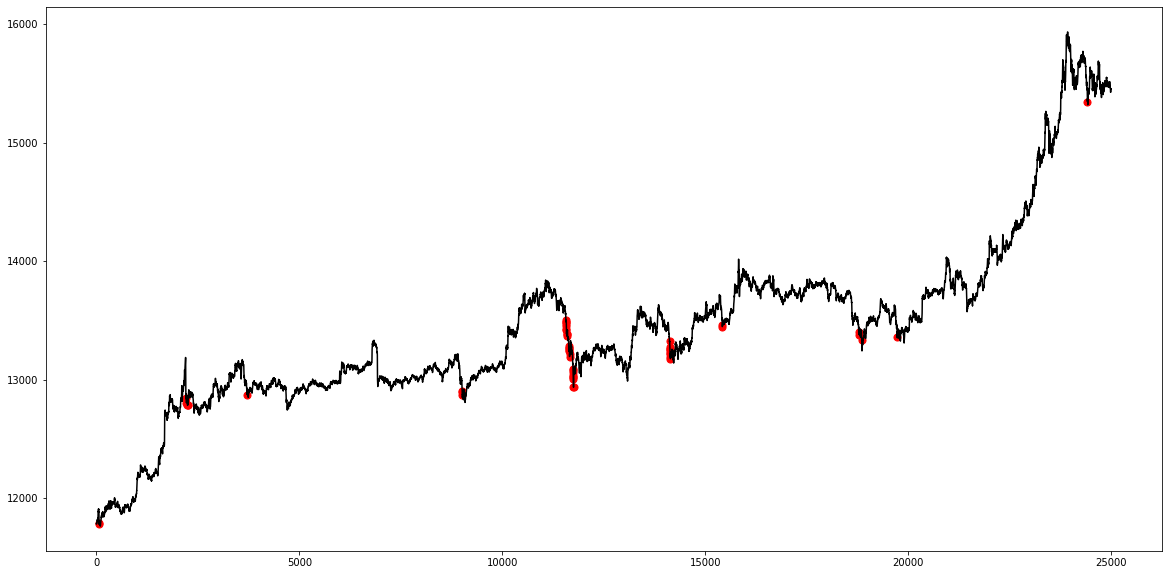

In [237]:
nu.graphPoints(smaller_view_data, mode="buy", plot_optimal=False)

In [239]:
model_version = nu.exportModel(clf, model_name, new_version=False, indicators=indicators, features=features, proba_threshold=0.7, is_nn=False)

In [162]:
# score, trades = nu.testModel(model_name)

In [163]:
# updateScoreboard(model_name, model_version, score, trades, features)

In [164]:
#1.5 is the best one. XGBoost with no time features
#1.6 is next one with RF and time features